# This file will serve as the main testing ground for a variety of signals for the CRSP data set

## The multiple strategies are the underlying:

### 1. Univariate Strategies
   * MACD (momentum), bollinger bands (mean reversion), univariate KRR
   
### 2. Multivariate Strategies
   * multivariate KRR, VAR
   
### 3. NN-based methodologies
   
### 4. Others? (eg. from academic literature)

### Further to do:
   * include fractional differentiation to maximise memory & keep stationarity
   * perform necessary statistical tests on VAR & its parameters
        * get VAR to work only with cointegrated pairs
   * generally: optimize code & parallelize operations

# Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels as sm
from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import *
from sklearn.kernel_ridge import *
import math
import scipy
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [2]:
data  = pd.read_csv('data/returns.csv')
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index)
data = data.iloc[:,:50]

# Univariate strategies
* Simple strategies
    + mean reversion -> DONE
    + momentum (MACD) -> DONE
* forecasting strategies (requires cross-validation procedure)
    + ARMA
    + KRR (extremely slow) -> DONE

In [471]:
def macd(ret, long=26, short=12, signal_span=9, plot=False):

    short_signal = ret.ewm(span=short, adjust=False).mean()
    long_signal = ret.ewm(span=long, adjust=False).mean() 
    macd = short_signal - long_signal
    
    pos = np.zeros(len(ret))
    pos = np.where(macd>0,1,-1)
    
    if plot==True:
        %matplotlib widget
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(ret.index[:100],signal[:100], label = 'signal', color='g')
        ax.plot(ret.index[:100],macd[:100], label = 'macd', color = 'b')
        ax.legend(loc=1)
        ax.set_xlabel("time")
        ax.set_ylabel("MACD/SIGNAL")
        
        months = mdates.MonthLocator()
        ax.xaxis.set_major_locator(months) 
        fig.autofmt_xdate()
        
        ax2 = ax.twinx()
        ax2.stem(stock.index[:100],position[:100])
        ax2.set_ylabel("position (1 for long, 0 for none, -1 for short)")
        ax2.set_ylim(-3,3)
        ax.set_title("MACD strategy visualised with positions as stems for first 100 observations")
        plt.show()
    
    return pos

def macd_signals(returns,long=26,short=12,signal_span=9):
    signals = pd.DataFrame()
    for i in range(returns.shape[1]):
        signals['signal_{}'.format(i)] = macd(returns.iloc[:,i],long,short,signal_span)
    signals.index = returns.index
    return signals.shift(1).fillna(0)

# figure out way to use this function -> more efficient code
def rolling_pipe(dataframe, window, fctn):
    return pd.Series([dataframe.iloc[i-window: i].pipe(fctn) 
                      if i >= window else None 
                      for i in range(1, len(dataframe)+1)],
                     index = dataframe.index) 

# bollinger bands: mean reversion
def rev(ret,lookback,band,plot):
    # work with prices
    p = (ret+1).cumprod()
    # obtain mean & vol
    m = p.rolling(window=lookback).mean()
    s = p.rolling(window=lookback).std()
    lower_band = m - band*s
    higher_band = m + band*s
    
    #signal = np.where(ret > higher_band,-1,
    #                  np.where(ret < m, 0,
    #                           np.where(ret < lower_band, 1,0)))
    
    signal2 = np.zeros(len(ret))
    position_short = False
    position_long = False
    for i in range(len(ret)):
        # sell if higher than band
        if p[i] > higher_band[i]:
            signal2[i] = -1
            position_short = True
        # sell back if from lower band to mean
        elif p[i] < higher_band[i] and p.iloc[i] > m[i] and position_long == True:
            signal2[i] = 0
            position_long = False
        # buy back if from higher band to mean
        elif p[i] < m[i] and position_short == True:
            signal2[i] = 0
            position_short = False
        # buy if lower barrier hit
        elif p[i] < lower_band[i]:
            signal2[i] = 1
            position_long = True
        else:
            signal2[i] = signal2[i-1]
        

    if plot==True:
        %matplotlib widget
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(ret.index,lower_band, label = 'lower', color='b')
        ax.plot(ret.index,higher_band, label = 'higher', color = 'b')
        ax.plot(ret.index,m, label = 'mean', color = 'b')
        ax.plot(ret.index,p,label="returns", color="r")

        ax.legend(loc=1)
        ax.set_xlabel("TIME")
        ax.set_ylabel("PRICE")

        months = mdates.MonthLocator()
        ax.xaxis.set_major_locator(months) 
        fig.autofmt_xdate()

        plt.show()
        
    return signal2


def reversion_signals(returns,lookback=100,band=2,plot=False):
    signals = pd.DataFrame()
    for i in range(returns.shape[1]):
        signals['signal_{}'.format(i)] = rev(ret = returns.iloc[:,i],lookback=lookback,band=band,plot=plot)
    signals.index = returns.index
    return signals.shift(1).fillna(0)

# kernel ridge
def krr_signals(data,window_size=30,npredictions=5):
    n = len(data)-1
    predicted_values = np.zeros(n+npredictions+1)

    
    # rolling window
    for i in range(window_size,n,npredictions):
        if i % 100 == 0: print('{} % done'.format(round(i/(n-30)*100)),end="\r")
        #    print(i)
                
        list_x = np.array(data.iloc[(i-window_size):i]).reshape(-1,1)
        list_y = np.array(data.iloc[(i-window_size+1):(i+1)]) 
        list_x_pred = np.array(data.iloc[i:(i+npredictions)]).reshape(-1,1)
        
        parameters = {'kernel':['rbf'], 'alpha':np.arange(0.001,3,1).tolist(),'degree':np.arange(0.001,3,1).tolist()}
        clf = GridSearchCV(KernelRidge(), parameters)
        clf = clf.fit(list_x,list_y)
        pred = clf.predict(list_x_pred)
        predicted_values[i:(i+npredictions)] = pred
    
    # turn values into signals
    signals = np.where(predicted_values > 0,1,-1)
    
    return signals
def krr_signals_univ(data,window_size=30,npredictions=5):
    n = data.shape[0]
    signals = np.zeros((n+npredictions,data.shape[1]))
    for i in range(data.shape[1]):
        signals[:,i] = krr_signals(data.iloc[:,i],window_size=window_size,npredictions=npredictions)
    return signals


# Multivariate Econometric
   * Vector Autoregressive (VAR) -> DONE
   * Vector error correction models (VECM)
   * Kernel Ridge Regression (KRR) -> DONE

### Statistical tests
   * **Granger causality** (column var causes row var) -> rejection means good candidate for MV
       (tests the null hypothesis that the coefficients of past values in the regression equation is zero. In simpler terms, the past values of time series (X) do not cause the other series (Y))
   * **ADF test** -> need stationarity in time series
   * **cointegration** -> establish the presence of a statistically significant connection between two or more time series

In [462]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=4):    
    """
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def adfuller_test(series, signif=0.05):
    """Perform ADFuller to test for Stationarity of given series of returns and print report"""
    for name, column in series.iteritems():
        r = adfuller(column, autolag='BIC')
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue']
        if p_value > signif:
            print("series {} is non-stationary".format(column.name))
            
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    # print output if failed
    for name, trace, cvt in zip(df.columns, traces, cvts):
        if trace < cvt: print("column {} failed the cointegration test".format(name))

def multivariate_tests(data,alpha=0.05,maxlag=4, test = 'ssr_chi2test'):
    """
    data: pandas dataframe
    alpha: significance level
    maxlag: maximum number of lags for granger causality test
    test: test for granger causality
    
    what it does: prints failed adf and cointegration tests
    
    returns: granger causality matrix
    """
    adfuller_test(data, signif=alpha)
    cointegration_test(data, alpha=alpha)
    
    return grangers_causation_matrix(data, data.columns, test=test, maxlag=maxlag)

### VAR model
still requires some code optimisation

suggested improvements: build model using solely cointegrated time series -> can include more lags

In [463]:
def var(df, window=30,maxlag=3,npredictions=5):
    
    n = len(df)
    # initiate forecasts dataframe
    forecasts = np.zeros((n+npredictions,df.shape[1])) 
    
    # rolling window approach
    for i in range(window,n,npredictions):
        if i % 250 == 0: print('{}% done'.format(round(i/(n-30)*100)),end="\r")
        bic_list = []
        series = df.iloc[(i-window):i,:]
        model = VAR(series)
        
        # optimal lags and fitting
        for j in np.arange(0,maxlag+1,1):
            try:
                result = model.fit(j)
                bic_list.append(result.bic)
            except:
                print("cannot deal with lag of {}, restarting with maxlag of {}".format(j,maxlag-1))
                if maxlag == 0:
                    print("window size too small relative to number of assets, please restart")
                    return 0
                else:
                    return var(df, window, maxlag-1)
        
        # final check
        if len(bic_list) == 1:
                print("window size too small relative to number of assets, please restart")
                return 0   
            
        nbr_lags = bic_list.index(min(bic_list)) + 1
        model_fitted = model.fit(nbr_lags)

        forecast_input = series.values[-nbr_lags:]
        
        fc = model_fitted.forecast(y=forecast_input, steps=npredictions)
        forecasts[i:(i+npredictions),:] = fc
        
    signals = np.where(forecasts > 0,1,-1)

                
    return signals

def krr_signals_mv(data,window_size=30,npredictions=5):
    n = len(data)-1

    predicted_values = np.zeros((n+npredictions+1,data.shape[1]))    

    # rolling window
    # re-fit the model every "npredictions" days
    for i in range(window_size,n,npredictions):
        if i % 100 == 0: print('{} % done'.format(round(i/(n-window_size)*100)),end="\r")
        begin = i - window_size
        
        # obtain principal components, section 2.5
        pca = PCA(n_components=4)
        principalComponents = pca.fit_transform(np.array(data.iloc[begin:i,:]))
        
        principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1','pc2','pc3','pc4'])
        
        model = linear_model.LinearRegression()
        model_score = model.fit(principalDf,data.iloc[begin:i,:]).score(principalDf,data.iloc[begin:i,:])
        
        x = np.array(data.iloc[(i-window_size):i,:])#.reshape(-1,1)
        y = np.array(data.iloc[(i-window_size+1):(i+1),:]) 
        x_pred = np.array(data.iloc[i:(i+npredictions),:])
        
        # gaussian kernel parameters
        nbr_assets = data.shape[1]
        df = window_size - nbr_assets
        if df<0:df=1 # for chi-square
        r2 = np.array(model_score)
        sigma0 = math.sqrt(chi2.ppf(0.95,df)) / math.pi
        sigma = np.array([0.5*sigma0,sigma0,2*sigma0,4*sigma0,8*sigma0])
        lambda0 = (1-r2)/(r2)
        lambdaa = np.array([lambda0/8.0,lambda0/4.0,lambda0/2.0,lambda0,2*lambda0])
        
        parameters = {'kernel':['rbf'], 'alpha':lambdaa.tolist(),'degree':[2]}
        clf = GridSearchCV(KernelRidge(), parameters)
        clf = clf.fit(x,y)
        pred = clf.predict(x_pred)
        predicted_values[i:(i+npredictions),:] = pred
    
    # turn values into signals
    signals = np.where(predicted_values > 0,1,-1)
    
    return signals

# NN-based methodologies
   * LSTM
   * CNN
   * prophet (Facebook)
   * other?

# (initial) Testing the strategies

Conclusions:
   * standard MACD, mean reversion and VAR are bad strategies, all beaten by long only
   * KRR performs very well on average

In [464]:
# performance evaluation
def pnl(data,signals):
    d = np.array(data)
    s = np.array(signals)
    return (1 + pd.DataFrame(np.multiply(d,s), index=data.index)).cumprod()

In [465]:
stocks = data
# 1. test macd
macd_multiple = macd_signals(stocks,26,12,9)
print("macd done")
# 2. test mean reversion
#m_r = reversion_signals(stocks)
print("mean reversion done")
# 3. test krr univariate
krr_univ = krr_signals_univ(stocks)
print("krr univariate done")
# 4. test krr multivariate
krr_mv = krr_signals_mv(stocks)
print("krr multivariate done")
# 5. test VAR -> cannot deal with very high dimensions
var_s = var(stocks.iloc[:,:5],window = 30,maxlag=3,npredictions=5)

macd done
mean reversion done
krr univariate done
krr multivariate done


In [473]:
macd_perf = pnl(stocks,macd_multiple)
m_r_perf = pnl(stocks,m_r)
krr_perf = pnl(stocks,krr_mv[:-5,:])
#krr2_perf = pnl(stocks,krr_univ[:-5,:])
var_perf = pnl(stocks.iloc[:,:5],var_s[:-5,:])

# skip first 30 days -> window size
macd_perf = macd_perf.iloc[30:,:]
m_r_perf = m_r_perf.iloc[30:,:]
krr_perf = krr_perf.iloc[30:,:]
#krr2_perf = krr2_perf.iloc[30:,:]
var_perf = var_perf.iloc[30:,:]
long_only = (1+stocks.iloc[30:,:]).cumprod()

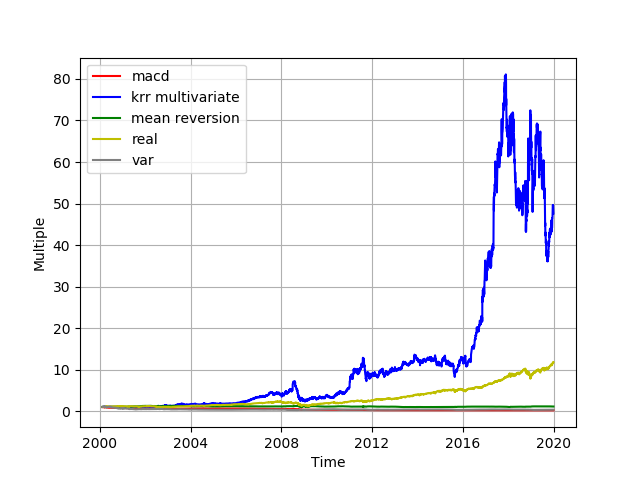

In [476]:
index = macd_perf.index
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(index,macd_perf.mean(axis=1), label = 'macd', color = 'r')
ax.plot(index,krr_perf.mean(axis=1), label = 'krr multivariate', color = 'b')
#ax.plot(index,krr2_perf.mean(axis=1), label = 'krr univariate', color = 'b')
ax.plot(index,m_r_perf.mean(axis=1), label = 'mean reversion', color = 'g')
ax.plot(index,long_only.mean(axis=1), label = 'real', color = 'y')
ax.plot(index,var_perf.mean(axis=1), label = 'var', color = 'gray')

ax.legend(loc=0)
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Multiple")
#ax2.set_ylabel("pred")
plt.show()